In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
import pandas as pd

In [2]:
import pandas as pd
import gmplot as gp
from matplotlib.colors import to_hex

def plot_gmplot(input, channel=0, map_name='gmap.html', size=50):
    # channel: 0, 1, 2 refers to RGB
    
    df_unique = pd.read_csv('df_unique.csv')
    mean_lat = df_unique.latitude.mean()
    mean_lng = df_unique.longitude.mean()
    
    with open('apikey.txt') as f:
        apikey = f.readlines()[0]

    colour = np.zeros(input.shape)

    for i, c in enumerate(input[:, channel]):
        if c > 0:
            colour[i, channel] = c
        else:
            for k in range(3):
                if k!=channel:
                    colour[i, k] = -c
    
    colour = colour / np.max(colour.flatten())
    colour_hex = [None] * len(colour)

    for i, color in enumerate(colour):
        colour_hex[i] = to_hex(color)
    
    gmap = gp.GoogleMapPlotter(mean_lat, mean_lng, 8, apikey = apikey)
    gmap.scatter(list(df_unique.latitude), list(df_unique.longitude), size = size, color=colour_hex, marker=False) 
    gmap.draw(map_name)
    
    return list(df_unique.latitude), list(df_unique.longitude), colour_hex, colour

In [3]:
n_components = 3

In [4]:
input = np.load('bh_observations.npy')

In [5]:
input.shape

(10, 561)

In [6]:
pca = PCA(n_components=n_components)
pca_sources = pca.fit_transform(input)
pca.explained_variance_ratio_

array([0.46051456, 0.20711781, 0.10397956])

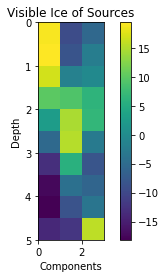

In [7]:
plt.imshow(pca_sources, interpolation = 'none', extent=[0, pca_sources.shape[1], 5, 0])
ax = plt.gca()
ax.set_aspect(2)
plt.colorbar()
plt.title("Visible Ice of Sources")
plt.xlabel("Components")
plt.ylabel('Depth')
# plt.savefig('components_analysis/components_n{}.png'.format(n_components))
plt.show()

In [8]:
pca_h = PCA(n_components=n_components)
pca_h_sources = pca_h.fit_transform(input.T)
pca_h.explained_variance_ratio_

array([0.51903607, 0.21231796, 0.09981609])

In [9]:
pca_h_sources.shape

(561, 3)

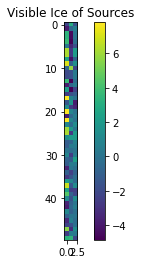

In [10]:
plt.imshow(pca_h_sources[0:50])
plt.title("Visible Ice of Sources")
plt.colorbar()
plt.show()

In [11]:
ica_h = FastICA(n_components=n_components, random_state=0)

ica_h_sources = ica_h.fit_transform(input.T)
mix = ica_h.mixing_

In [12]:
ica_h_sources.shape

(561, 3)

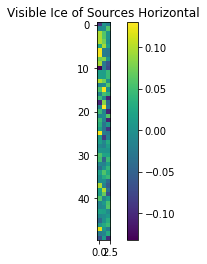

In [13]:
plt.imshow(ica_h_sources[0:50])
plt.title("Visible Ice of Sources Horizontal")
plt.colorbar()
plt.show()

In [14]:
ica_h.mean_.shape

(10,)

In [15]:
channel = 2
lat, lng, colour_hex, colour = plot_gmplot(ica_h_sources[:, 0:3], channel=channel, map_name='ica_h_channel_{}.html'.format(channel))

In [16]:
mix.shape

(10, 3)

In [17]:
np.max(mix, axis=0)

array([ 21.91649423,  16.35216557, -16.7960873 ])

In [18]:
np.min(mix, axis=0)

array([-12.88276843, -14.93057284, -22.73903592])

In [19]:
mix[:,-1] *= -1 

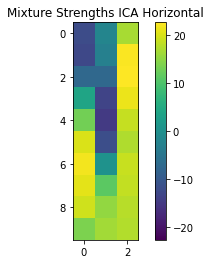

In [20]:
max_val = np.amax(abs(mix))
plt.imshow(mix, vmin = -max_val, vmax=max_val)
plt.title('Mixture Strengths ICA Horizontal')
plt.colorbar()
plt.show()

In [21]:
last_source = ica_h_sources[:, -1]

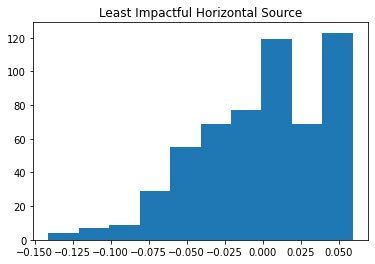

In [22]:
plt.hist(last_source)
plt.title("Least Impactful Horizontal Source")
plt.show()

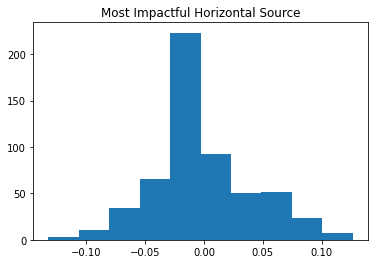

In [23]:
plt.hist(ica_h_sources[:, 0])
plt.title("Most Impactful Horizontal Source")
plt.show()